# Take a small NN and see if it can approximate an equation

The equation we are using is 

y = ax^4 + bx^3 + cx^2 + dx + f

In [8]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [469]:
np.random.seed(10)

def f(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def frand(x):
    return f(x) + np.random.uniform(-0.5, 0.5, x.shape).astype('f')

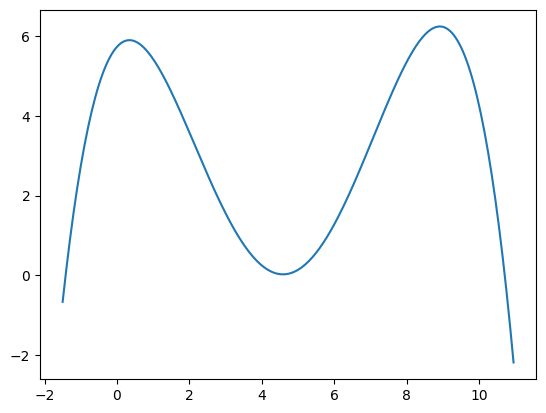

In [467]:
xs = np.arange(-1.5, 11, .05)
ys = f(xs)
plt.plot(xs, ys)

In [470]:
# Add some small error to Y
# Generate 10 random numbers between -.1 and .1
#random_numbers = np.random.uniform(-0.5, 0.5, ys.size)
#yrand = ys + random_numbers
yrand = frand(xs)
yrand.shape

(250,)

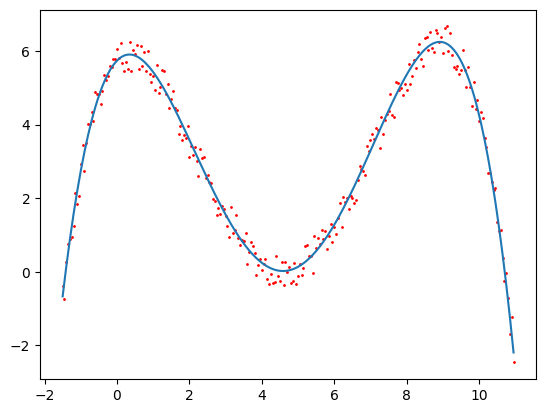

In [471]:
plt.plot(xs, ys)
plt.scatter(xs, yrand, color='red',s=1)

# Display the plot
plt.show()

In [493]:
# we should add more samples in the beginning (x = -1.5 to 0) and end (9 to 11) as there is less data there
xs2 = np.arange(-1.5, 0, .01)
xs3 = np.arange(9, 11, .01)
xs = np.append(xs, xs2)
xs = np.sort(np.append(xs, xs3))

In [427]:
xs.shape

(600,)

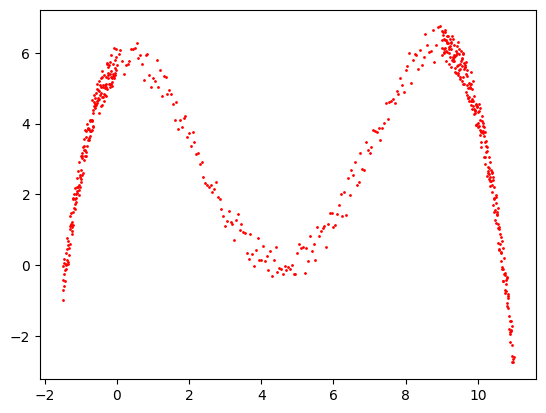

In [852]:
plt.scatter(xs, frand(xs), color='red', s=1)

# Display the plot
plt.show()

In [846]:
import torch

import torch.nn as nn
import torch.nn.functional as F

class SingleHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SingleHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = self.fc2(x)
        return x


## Model Definition

In [681]:
torch.manual_seed(10)
model = SingleHiddenLayerNet(1, 4, 1)

In [682]:
#plot untrained model
x = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)
y = model(x)
yout = y.data.reshape(xs.shape[0])

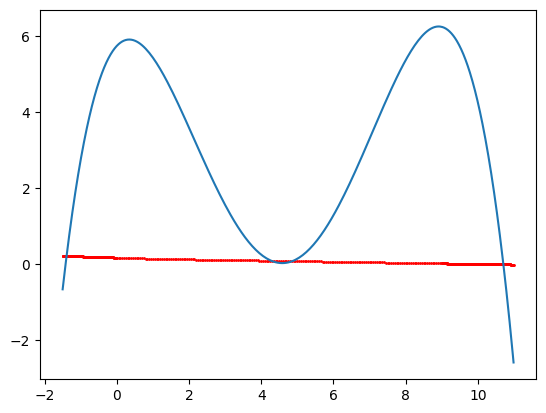

In [683]:
plt.plot(xs, f(xs))
plt.scatter(xs, yout, color='red', s=1)

# Display the plot
plt.show()

In [684]:
# Show values of weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name, '\n', param)
    elif 'bias' in name:
        print(name, '\n', param)

fc1.weight 
 Parameter containing:
tensor([[-0.0838],
        [-0.0343],
        [-0.3750],
        [ 0.2300]], requires_grad=True)
fc1.bias 
 Parameter containing:
tensor([-0.5721, -0.1763,  0.3876,  0.9386], requires_grad=True)
fc2.weight 
 Parameter containing:
tensor([[ 0.1178, -0.1696,  0.0479, -0.0560]], requires_grad=True)
fc2.bias 
 Parameter containing:
tensor([0.2041], requires_grad=True)


You can then train the network using a loss function and an optimizer. For example, the following code trains the network using the mean squared error loss function and the Adam optimizer:

In [509]:
from torch.utils.data.dataloader import DataLoader

class InfiniteDataLoader:
    """
    this is really hacky and I'm not proud of it, but there doesn't seem to be
    a better way in PyTorch to just create an infinite dataloader?
    """

    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


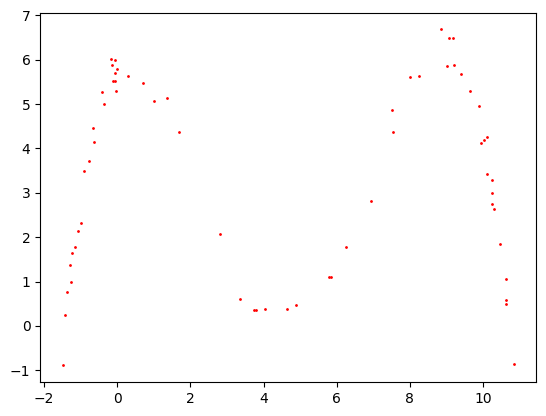

In [732]:
# test the batch loader
batch_loader = InfiniteDataLoader(x, batch_size=64, pin_memory=True, num_workers=1)

X = batch_loader.next()
Y = frand(X)

plt.scatter(X, Y, color='red',s=1)
# Display the plot
plt.show()

## Training the model

In [730]:
# new way to optimize in batches
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, betas=(0.9, 0.99), eps=1e-8)

criterion = nn.MSELoss()

# init dataloader
batch_loader = InfiniteDataLoader(x, batch_size=64, pin_memory=True, num_workers=1)

# training loop
best_loss = None
step = 0
max_steps = 1000

while True:

    t0 = time.time()

    # get the next batch, ship to device, and unpack it to input and target
    X = batch_loader.next()
    Y = frand(X)

    # Forward pass
    ypred = model(X)

    # Calculate the loss
    loss = criterion(ypred, Y)

    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for 
    t1 = time.time()

    # logging
    if step % 100 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    step += 1
    # termination conditions
    if max_steps >= 0 and step >= max_steps:
        break


step 0 | loss 0.3403 | step time 588.24ms
step 100 | loss 0.4096 | step time 0.42ms
step 200 | loss 0.5416 | step time 0.40ms
step 300 | loss 0.3698 | step time 0.40ms
step 400 | loss 0.6141 | step time 0.40ms
step 500 | loss 0.4423 | step time 0.63ms
step 600 | loss 0.3907 | step time 0.40ms
step 700 | loss 0.4148 | step time 0.41ms
step 800 | loss 0.4388 | step time 0.40ms
step 900 | loss 0.3755 | step time 0.42ms


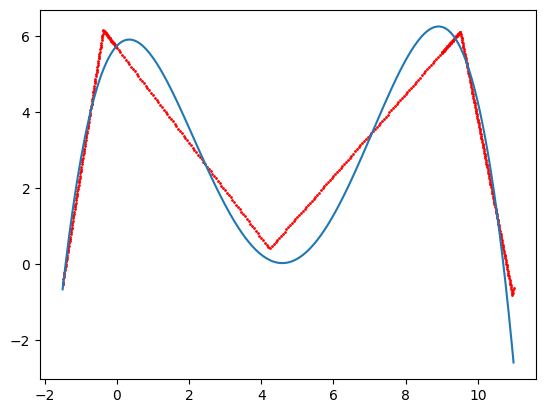

In [731]:
# plot trained model
y = model(x)
yout = y.data.reshape(xs.shape[0])
plt.plot(xs, target.data.reshape(xs.shape[0]))
plt.scatter(xs, yout, color='red', s=1)

# Display the plot
plt.show()

In [733]:
# Show values of weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name, '\n', param)
    elif 'bias' in name:
        print(name, '\n', param)

fc1.weight 
 Parameter containing:
tensor([[ 0.6501],
        [-2.8519],
        [-0.8007],
        [ 0.3100]], requires_grad=True)
fc1.bias 
 Parameter containing:
tensor([-7.1258, -1.0651,  3.3868, -2.9498], requires_grad=True)
fc2.weight 
 Parameter containing:
tensor([[ 18.3542,  -2.7969,   3.2340, -21.0270]], requires_grad=True)
fc2.bias 
 Parameter containing:
tensor([1.3126], requires_grad=True)


In [838]:
# Fetch model parameter by name
def fetch_param(name_in):
    for name, param in model.named_parameters():
        if name == name_in:
            weight_tensor = param
            break
    return weight_tensor.detach().numpy()

#leaky relu 
def lru(x):
    if(x < 0):
        return x*0.1
    return x

In [812]:
fetch_param('fc2.weight')[0,0]

18.354242

## plot the Y point using weights & biases

In [955]:
def nnforward(x):
    z11 = lru(x*fetch_param('fc1.weight')[0][0] + fetch_param('fc1.bias')[0])
    z12 = lru(x*fetch_param('fc1.weight')[1][0] + fetch_param('fc1.bias')[1])
    z13 = lru(x*fetch_param('fc1.weight')[2][0] + fetch_param('fc1.bias')[2])
    z14 = lru(x*fetch_param('fc1.weight')[3][0] + fetch_param('fc1.bias')[3])
    
    y1 = fetch_param('fc2.weight')[0,0] * z11
    y2 = fetch_param('fc2.weight')[0,1] * z12
    y3 = fetch_param('fc2.weight')[0,2] * z13
    y4 = fetch_param('fc2.weight')[0,3] * z14
    y5 = fetch_param('fc2.bias')[0]
    y = y1 + y2 + y3 + y4 + y5
    #return y, y1, y2, y3, y4, y5
    return y, z11, z12, z13, z14, y5

""" My Understanding
For a single layer network each neuron with RELU activation function 
1. Represents a line with slope of 0 and another line with slope of fc1.weight*fc2.weight at that neuron.
2. The intesect of these two lines is at x = -fc1.bias/fc1.weight for each neuron in 1st layer.
3. The y value for this neuron is cumulative y of all the neuron lines
"""

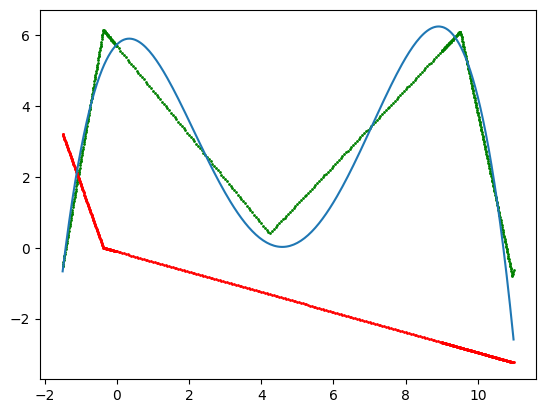

In [972]:
ynn = np.zeros_like(xs)
y1 = np.zeros_like(xs)
y2 = np.zeros_like(xs)
y3 = np.zeros_like(xs)
y4 = np.zeros_like(xs)
y5 = np.zeros_like(xs)

i = 0
for x in xs:
    ynn[i], y1[i], y2[i], y3[i], y4[i], y5[i]  = nnforward(x)
    i += 1

# plot trained model
plt.plot(xs, target.data.reshape(xs.shape[0]))
plt.scatter(xs, ynn, color='green', s=1)
plt.scatter(xs, y2, color='red', s=1)
#plt.scatter(xs, , color='gray', s=1)
# Display the plot
plt.show()

In [849]:

class TwoHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(TwoHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = self.fc3(x)
        return x

## change model to add one more layer

In [899]:
model2 = TwoHiddenLayerNet(1, 4, 2, 1)

In [931]:
# new way to optimize in batches
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

newmodel = model2

# init optimizer
optimizer = torch.optim.AdamW(newmodel.parameters(), lr=.01, betas=(0.9, 0.99), eps=1e-8)
criterion = nn.MSELoss()

# init dataloader
x = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)
batch_loader = InfiniteDataLoader(x, batch_size=64, pin_memory=True, num_workers=1)

# training loop
best_loss = None
step = 0
max_steps = 1000

while True:

    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X = batch_loader.next()
    Y = frand(X)

    # Forward pass
    ypred = newmodel(X)

    # Calculate the loss
    loss = criterion(ypred, Y)

    # Backward and optimize
    newmodel.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for 
    t1 = time.time()

    # logging
    if step % 100 == 0:
        print(f"step {step} | loss {loss.item():.4f} | step time {(t1-t0)*1000:.2f}ms")

    step += 1
    # termination conditions
    if max_steps >= 0 and step >= max_steps:
        break


step 0 | loss 3.2838 | step time 575.70ms
step 100 | loss 0.8280 | step time 0.50ms
step 200 | loss 0.3515 | step time 0.49ms
step 300 | loss 0.3816 | step time 0.48ms
step 400 | loss 0.2717 | step time 0.48ms
step 500 | loss 0.2523 | step time 0.49ms
step 600 | loss 0.2628 | step time 0.48ms
step 700 | loss 0.2294 | step time 0.48ms
step 800 | loss 0.2826 | step time 0.47ms
step 900 | loss 0.2773 | step time 0.49ms


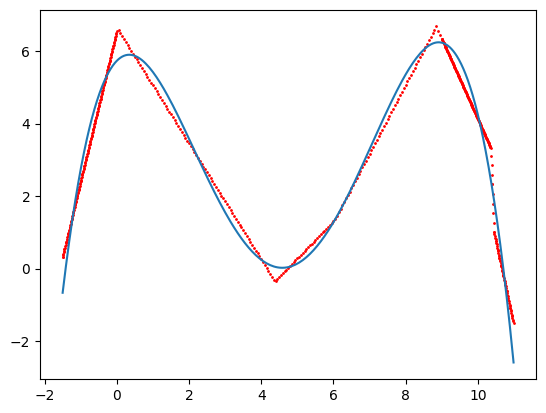

In [932]:
# plot trained model
y = model2(x)
yout = y.data.reshape(xs.shape[0])
plt.plot(xs, target.data.reshape(xs.shape[0]))
plt.scatter(xs, yout, color='red', s=1)

# Display the plot
plt.show()

In [866]:
# Show values of weights and biases
for name, param in newmodel.named_parameters():
    if 'weight' in name:
        print(name, '\n', param)
    elif 'bias' in name:
        print(name, '\n', param)

fc1.weight 
 Parameter containing:
tensor([[-0.0909],
        [ 0.2326],
        [-0.0896],
        [-0.0424]], requires_grad=True)
fc1.bias 
 Parameter containing:
tensor([-1.6065,  1.2854,  2.2504,  2.2111], requires_grad=True)
fc2.weight 
 Parameter containing:
tensor([[ 0.4430, -0.3678, -1.5289, -0.7597],
        [ 0.2257, -0.3727, -1.3977, -1.2812]], requires_grad=True)
fc2.bias 
 Parameter containing:
tensor([-1.7145, -1.7598], requires_grad=True)
fc3.weight 
 Parameter containing:
tensor([[-0.9439, -1.0477]], requires_grad=True)
fc3.bias 
 Parameter containing:
tensor([1.6971], requires_grad=True)
